In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import librosa
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/woongjae/XAI')
from SSL_aasist.model import Model

from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances
from transformers import pipeline

/home/woongjae/miniconda3/envs/aasist/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def evaluate_single_audio(model, audio_path, device="cpu", sr=16000):
    """
    단일 오디오 파일을 모델에 넣어 real/fake 확률과 예측 레이블 반환
    Args:
        model: 학습된 PyTorch 모델
        audio_path (str): wav 파일 경로
        device (str): "cpu" 또는 "cuda"
        sr (int): 리샘플링할 샘플링 레이트 (기본=16000)
    
    Returns:
        dict: {
            "file": 파일 경로,
            "pred": 0=bonafide, 1=spoof,
            "real_score": bonafide 확률,
            "fake_score": spoof 확률
        }
    """
    # 오디오 불러오기
    waveform, _ = librosa.load(audio_path, sr=sr)
    waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T]

    # 추론
    model.eval()
    with torch.no_grad():
        output = model(waveform)  # [1, 2]
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        score_real = prob[0, 0].item()
        score_fake = prob[0, 1].item()

    return {
        "file": audio_path,
        "pred": pred,
        "real_score": score_real,
        "fake_score": score_fake
    }, waveform

### Word-level masking

In [ ]:
def extract_word_segments_with_whisper(
    audio_path, sr=16000, model_name="openai/whisper-small",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Hugging Face transformers 기반 Whisper로 단어 단위 timestamp 추출
    return:
        segments: list of (start_sample, end_sample)
        words: list of 단어 문자열
        timestamps: list of (start_time_sec, end_time_sec)
    """
    asr = pipeline(
        "automatic-speech-recognition",
        model=model_name,
        device=0 if device.startswith("cuda") else -1,
        return_timestamps="word",
        generate_kwargs={"task": "transcribe"}
    )
    result = asr(audio_path)

    segments, words, timestamps = [], [], []

    # transformers==4.30+ 기준: result["chunks"]에 단어 단위가 들어옴
    chunks = result.get("chunks", [])
    for c in chunks:
        ts = c.get("timestamp", None)
        if not ts or ts[0] is None or ts[1] is None:
            continue
        start_s, end_s = float(ts[0]), float(ts[1])
        # 초 → 샘플 변환
        start = max(0, int(start_s * sr))
        end = max(start, int(end_s * sr))

        segments.append((start, end))
        words.append(c.get("text", "").strip())
        timestamps.append((start_s, end_s))

    # 로그 출력
    for w, (ts_start, ts_end) in zip(words, timestamps):
        print(f"Word: {w:15s} | Start: {ts_start:.2f}s | End: {ts_end:.2f}s")

    return segments, words, timestamps

In [4]:
def mask_waveform(waveform, segments, mask_idx):
    """
    특정 segment index들을 마스킹(0으로 대체)
    waveform: torch.Tensor [1, T]
    segments: list of (start_sample, end_sample)
    """
    masked = waveform.clone()
    for idx in mask_idx:
        start, end = segments[idx]
        masked[0, start:end] = 0.0
    return masked

In [5]:
def generate_lime_samples(model, waveform, segments, num_samples=100, device="cpu", use_logit=True, p_mask=0.3):
    """
    LIME용 샘플 생성 및 모델 점수 기록
    - 원본 모델이 예측한 class(logit or prob)를 기준으로 surrogate 학습
    """
    model.eval()
    # 원본 점수
    with torch.no_grad():
        output = model(waveform.to(device))  # [1,2]
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()   # 0=real, 1=spoof
        base_score = output[0, pred].item() if use_logit else prob[0, pred].item()

    print(f"[Baseline] pred={pred} ({'real' if pred==0 else 'spoof'}), score={base_score:.6f}, use_logit={use_logit}")

    X, y = [], []
    S = len(segments)

    for _ in range(num_samples):
        # 무작위 segment 마스킹
        mask_idx = [i for i in range(S) if np.random.rand() < p_mask]
        x_vec = np.ones(S, dtype=np.float32)
        if mask_idx:
            x_vec[mask_idx] = 0.0

        masked_wave = mask_waveform(waveform, segments, mask_idx).to(device)

        with torch.no_grad():
            out = model(masked_wave)
            if use_logit:
                score = out[0, pred].item()
            else:
                pr = torch.softmax(out, dim=1)
                score = pr[0, pred].item()

        X.append(x_vec)
        y.append(score)

    X = np.array(X)
    y = np.array(y)
    print(f"[LIME] Generated dataset: X={X.shape}, y={y.shape}")
    return X, y, base_score, pred


def fit_weighted_surrogate(X, y, base_vec, sigma=0.25):
    """
    Weighted Ridge surrogate with cosine similarity kernel
    """
    D = cosine_distances(X, base_vec.reshape(1, -1)).ravel()
    W = np.exp(-(D**2) / (sigma**2))
    surrogate = Ridge(alpha=1.0, fit_intercept=True)
    surrogate.fit(X, y, sample_weight=W)
    return surrogate, W

In [21]:
def plot_waveform_with_importance(waveform, importances, sr=16000, segments=None, top_ratio=0.1, title="Word-level LIME Importance", words=None):
    """
    Waveform + 중요 segment 시각화
    - 중요 segment: 빨간색 highlight
    - 단어 라벨: waveform 아래쪽에 표시
    """
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.squeeze().cpu().numpy()

    T = len(waveform)
    times = np.arange(T) / sr
    num_segments = len(importances)

    # 중요도 절댓값 기준 상위 segment index
    k = max(1, int(num_segments * top_ratio))
    top_idx = np.argsort(np.abs(importances))[-k:]

    plt.figure(figsize=(14, 4))
    plt.plot(times, waveform, color="black", linewidth=0.8)

    ymin, ymax = plt.ylim()

    if segments is not None:
        for idx in range(num_segments):
            start, end = segments[idx]
            s_t, e_t = start / sr, end / sr

            if idx in top_idx:
                # 주목 구간 → 빨간색 highlight
                plt.axvspan(s_t, e_t, color="red", alpha=0.3)

            if words and 0 <= idx < len(words):
                mid_t = (s_t + e_t) / 2
                # 단어를 waveform 아래쪽에 표시
                plt.text(mid_t, ymin - 0.1 * (ymax - ymin), words[idx],
                         ha="center", va="top", fontsize=9, rotation=0)

    plt.title(title)
    # plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

### surrogate model

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances

def fit_weighted_surrogate(X, y, base_vec, sigma=0.25):
    """
    Weighted Ridge surrogate with cosine similarity kernel
    Args:
        X: (num_samples, num_segments) binary mask vectors
        y: (num_samples,) target scores
        base_vec: (num_segments,) all-ones vector (원본 샘플)
        sigma: kernel width (작을수록 가까운 샘플에만 집중)
    """
    # 거리 계산 (cosine distance)
    D = cosine_distances(X, base_vec.reshape(1, -1)).ravel()
    
    # 유사도 → 가중치 변환
    W = np.exp(-(D**2) / (sigma**2))
    
    # Weighted Ridge 회귀
    surrogate = Ridge(alpha=1.0, fit_intercept=True)
    surrogate.fit(X, y, sample_weight=W)
    
    return surrogate, W

### LIME

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr = 16000

model_path = "/home/woongjae/XAI/SSL_aasist/Best_LA_model_for_DF.pth"
audio_path = "/home/woongjae/XAI/LIME/myaudio_2.wav"

# ---- 모델 로드 (형 코드와 동일) ----
model = Model(None, device)
model = nn.DataParallel(model).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded:", model_path)

# ---- Baseline 예측 + waveform 준비 ----
result, waveform = evaluate_single_audio(model, audio_path, device=device, sr=sr)
print("[Eval] ", result)
# waveform: torch [1, T]

# ---- Word-level segments 추출 (Whisper via transformers) ----
print("Extracting word-level segments with transformers Whisper...")
segments, words = extract_word_segments_with_whisper(audio_path, sr=sr, model_name="openai/whisper-small", device=str(device))
print(f"Total word segments: {len(segments)}")
if len(segments) == 0:
    raise RuntimeError("No word-level segments found. Check audio language/model or try a larger Whisper model.")

# ---- LIME 샘플 생성 ----
X, y, base_score, pred = generate_lime_samples(
    model=model,
    waveform=waveform,
    segments=segments,
    num_samples=200,
    device=device,
    use_logit=True,
    p_mask=0.3
)

# ---- Surrogate 학습 ----
base_vec = np.ones(X.shape[1], dtype=np.float32)
surrogate, W = fit_weighted_surrogate(X, y, base_vec, sigma=0.25)
importances = surrogate.coef_
print("[Surrogate] top-10 segments by |importance|:")
for i in np.argsort(np.abs(importances))[-10:][::-1]:
    wtxt = words[i] if (words and i < len(words)) else ""
    print(f"  idx={i:3d}, importance={importances[i]: .5f}, word='{wtxt}'")

Model loaded: /home/woongjae/XAI/SSL_aasist/Best_LA_model_for_DF.pth
[Eval]  {'file': '/home/woongjae/XAI/LIME/myaudio_2.wav', 'pred': 0, 'real_score': 0.9997618794441223, 'fake_score': 0.0002381567464908585}
Extracting word-level segments with transformers Whisper...


/home/woongjae/miniconda3/envs/aasist/lib/python3.8/site-packages/transformers/models/whisper/generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Total word segments: 14
[Baseline] pred=0 (real), score=4.764380, use_logit=True
[LIME] Generated dataset: X=(200, 14), y=(200,)
[Surrogate] top-10 segments by |importance|:
  idx=  8, importance= 0.04003, word='international'
  idx=  2, importance= 0.03599, word='held'
  idx=  0, importance= 0.03552, word='Scottish'
  idx= 11, importance= 0.02867, word='on'
  idx= 10, importance= 0.02587, word='appeared'
  idx=  3, importance= 0.02334, word='its'
  idx=  1, importance= 0.02198, word='football'
  idx=  9, importance= 0.01889, word='star'
  idx=  7, importance= 0.01348, word='future'
  idx=  4, importance= 0.00471, word='breath'


### visualization LIME on waveform

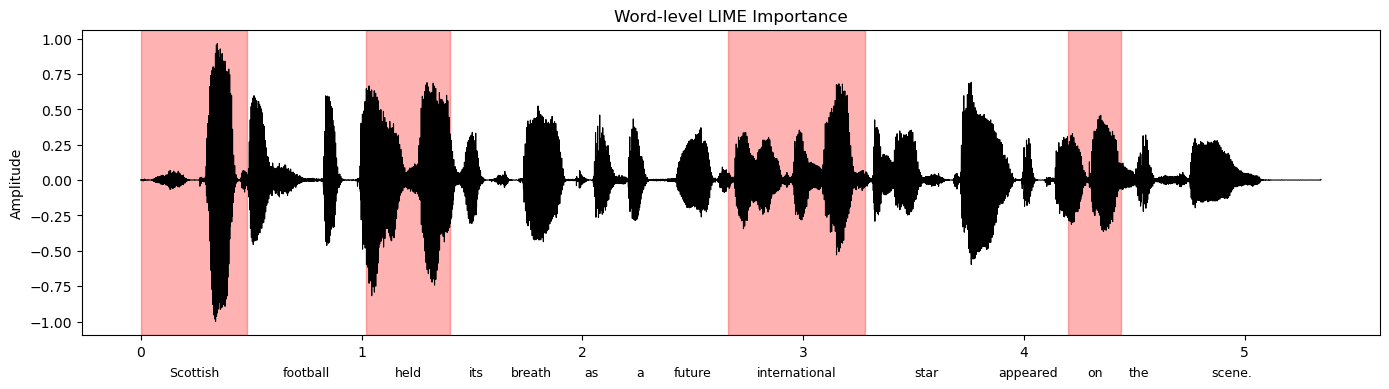

In [22]:
plot_waveform_with_importance(
    waveform=waveform,
    importances=importances,
    sr=sr,
    segments=segments,
    top_ratio=0.30,
    title="Word-level LIME Importance",
    words=words
)